## 标题：**使用PaddlePaddle进行黄金预测**

# 前言

能预测黄金价格走势曲线。

国内黄金价格和国际黄金价格曲线基本一致。

# 本模型效果图（亮点）
![](https://ai-studio-static-online.cdn.bcebos.com/fa98f86108af4edb928dd5fe67b0c359b55258ac05334b458bf3fab56209b69e)

# 目标
只需预测未来黄金价格曲线图，因为只需知道价格是上升还是下降，就有很大意义。
不用将价格预测准确，只需要将趋势图预测准确就可以。

# 个人方案
请大家把更新后的代码导出后，（点击右上角：文件-》导出为ipynb）
pull request到我github的这个文件:
[https://github.com/guojiahuiEmily/predictgoldprice/blob/main/predictgold.ipynb](https://github.com/guojiahuiEmily/predictgoldprice/blob/main/predictgold.ipynb)


# 分享成绩
并把自己的预测效果及截图分享到这里，看看谁的效果好：

[https://github.com/guojiahuiEmily/predictgoldprice/blob/main/rank](https://github.com/guojiahuiEmily/predictgoldprice/blob/main/rank)


# 一、灵感来源
   黄金价格对很多事件都有指导价值。



# 二、模型应用

# 时间卷积网络（TCN，Temporal Convolutional Networks）
时间序列是指按照时间先后顺序排列而成的序列，例如每日发电量、每小时营业额等组成的序列。通过分析时间序列中的发展过程、方向和趋势，我们可以预测下一段时间可能出现的情况。在本例中，我们使用时间卷积网络TCN进行建模，将学习到的特征接入全连接层完成预测。TCN的网络如下所示：

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/214011346cb24535ad57c50b936a2e4a207da6f7ce3b4e4babbe2571003f1aee" width="500" height="300" ></center>
<br><center>图1：TCN示意图</center></br>

图中是一个filters number=3, dilated rate=1的时间卷积网络，它能够学习前T个时序的数据特征。关于TCN更详细的资料请参考论文：[An Empirical Evaluation of Generic Convolutional and Recurrent Networks for Sequence Modeling](https://arxiv.org/pdf/1803.01271.pdf)。


# 三、代码展示

## 1、准备环境

我们首先需要导入必要的包。

这里我们使用`paddlenlp.seq2vec`中内置好的模型，关于`seq2vec`的详细介绍可参考这个项目：[seq2vec是什么? ](https://aistudio.baidu.com/aistudio/projectdetail/1283423)

In [ ]:
!pip install paddlenlp>=2.0.0b -i https://pypi.org/simple

如果上面运行失败可执行下面

In [ ]:
# !pip install --upgrade setuptools && python -m pip install --upgrade pip
# !pip install paddlenlp==2.0.0rc

In [ ]:


import os
import sys

import paddle
import paddle.nn as nn
import numpy as np

import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))
from paddlenlp.seq2vec import TCNEncoder

为了更好地展示数据结果，我们在这里配置画图功能。

In [ ]:
# config matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

## 2、数据

在csv文件夹内。您也可以点击左侧“数据集”，自己划分这3个文件。

## 3、数据预览

数据集中包含了国际每日黄金价格，单位：美元。

In [ ]:
df_all = pd.read_csv('csv/all.csv')
df_all.head()


,days,price
0,1978/12/29,226
1,1979/1/1,226
2,1979/1/2,227
3,1979/1/3,219
4,1979/1/4,223


我们将对价格曲线走势进行预测，不用预测准确价格。

In [ ]:

daily_cases = pd.read_csv('csv/all.csv',index_col=0,parse_dates=True, header=0,dtype= {'price': np.int32})
daily_cases.head()


,price
days,
1978-12-29,226
1979-01-01,226
1979-01-02,227
1979-01-03,219
1979-01-04,223


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


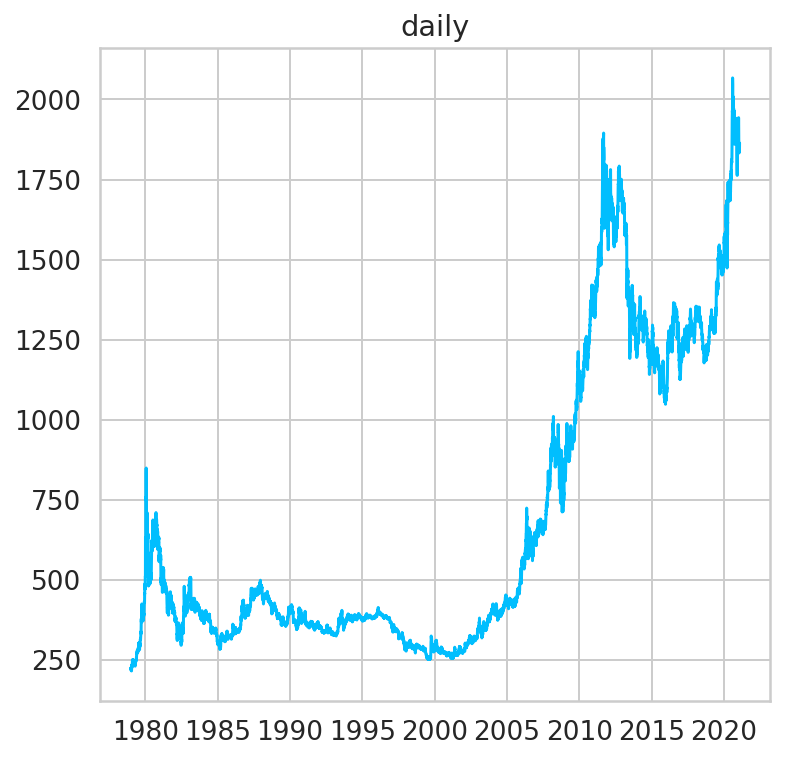

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(daily_cases)
plt.title("daily");

## 4、数据预处理

首先划分数据集为训练集与验证集，我们取最后30天的数据作为测试集，其余作为训练集。

In [ ]:
TEST_DATA_SIZE = 30

train_data = daily_cases[:-TEST_DATA_SIZE].astype('float32')
test_data = daily_cases[-TEST_DATA_SIZE:].astype('float32')

# train_data = train_data.astype('float32')

print("The number of the samples in train set is : %i"%train_data.shape[0])


The number of the samples in train set is : 10951


为了提升模型收敛速度与性能，我们使用scikit-learn进行数据归一化。

In [ ]:

print("The number of the samples in train set is : %i"%train_data.shape[0])
train_data.head()

The number of the samples in train set is : 10951


,price
days,
1978-12-29,226.0
1979-01-01,226.0
1979-01-02,227.0
1979-01-03,219.0
1979-01-04,223.0


In [ ]:

test_data.head()


,price
days,
2020-12-21,1880.0
2020-12-22,1877.0
2020-12-23,1875.0
2020-12-24,1875.0
2020-12-25,1875.0


In [ ]:
# print(f"bef train_data:{train_data[0]}")
# print(f"bef test_data:{test_data[0]}")

scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.fit_transform(test_data)
# train_data[0]
# test_data[0]

# print(f"after train_data:{train_data[0]}")
# print(f"after test_data:{test_data[0]}")

# train_data = scaler.fit_transform(np.expand_dims(train_data, axis=1)).astype('float32')
# test_data = scaler.transform(np.expand_dims(test_data, axis=1)).astype('float32')

现在开始组建时间序列

In [ ]:
SEQ_LEN = 30

def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length+1):
        x = data[i:i+seq_length-1]
        y = data[i+seq_length-1]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

x_train, y_train = create_sequences(train_data, SEQ_LEN)
test_data = np.concatenate((train_data[-SEQ_LEN+1:],test_data),axis=0)
x_test, y_test = create_sequences(test_data, SEQ_LEN)

print("The shape of x_train is: %s"%str(x_train.shape))
print("The shape of y_train is: %s"%str(y_train.shape))
print("The shape of x_test is: %s"%str(x_test.shape))
print("The shape of y_test is: %s"%str(y_test.shape))

The shape of x_train is: (10922, 29, 1)
The shape of y_train is: (10922, 1)
The shape of x_test is: (30, 29, 1)
The shape of y_test is: (30, 1)


数据集处理完毕，将数据集封装到CovidDataset，以便模型训练、预测时调用。

In [ ]:
class CovidDataset(paddle.io.Dataset):
    def __init__(self, feature, label):
        self.feature = feature
        self.label = label
        super(CovidDataset, self).__init__()

    def __len__(self):
        return len(self.label)

    def __getitem__(self, index):
        return [self.feature[index], self.label[index]]

train_dataset = CovidDataset(x_train, y_train)
test_dataset = CovidDataset(x_test, y_test)


## 5、组网

现在开始组建模型网络，我们采用时间卷积网络TCN作为特征提取器，将提取到的时序信息传送给全连接层获得最终的预测结果。

In [ ]:
class TimeSeriesNetwork(nn.Layer):

  def __init__(self, input_size, next_k=1, num_channels=[64,128,256]):
    super(TimeSeriesNetwork, self).__init__()

    self.last_num_channel = num_channels[-1]

    self.tcn = TCNEncoder(
      input_size=input_size,
      num_channels=num_channels,
      kernel_size=2, 
      dropout=0.2
    )

    self.linear = nn.Linear(in_features= self.last_num_channel, out_features=next_k)

  def forward(self, x):
    tcn_out = self.tcn(x)
    y_pred = self.linear(tcn_out)
    return y_pred

network = TimeSeriesNetwork(input_size=1)

## 6、定义优化器、损失函数

在这里我们使用Adam优化器、均方差损失函数，为启动训练做最后的准备。

In [ ]:
LR = 1e-3

model = paddle.Model(network)

optimizer = paddle.optimizer.Adam(
        learning_rate=LR, parameters=model.parameters())

loss = paddle.nn.MSELoss(reduction='sum')

model.prepare(optimizer, loss)

## 7、训练

配置必要的超参数，启动训练。

In [24]:
USE_GPU = True #The device should not be 'gpu', since PaddlePaddle is not compiled with CUDA
TRAIN_EPOCH = 100
LOG_FREQ = 10
SAVE_DIR = os.path.join(os.getcwd(),"save_dir")
SAVE_FREQ = 10

NAME_FLAG="1"

if USE_GPU:
    paddle.set_device("gpu")
else:
    paddle.set_device("cpu")

model.fit(train_dataset, 
    batch_size=32,
    drop_last=True,
    epochs=TRAIN_EPOCH,
    log_freq=LOG_FREQ,
    save_dir=SAVE_DIR,
    save_freq=SAVE_FREQ,
    verbose=1
    )


model.save('./model_save/'+NAME_FLAG)

The loss value printed in the log is the current step, and the metric is the average value of previous step.
Epoch 1/100
step 341/341 [==============================] - loss: 0.0179 - ETA: 6s - 20ms/st - loss: 0.0214 - ETA: 5s - 18ms/st - loss: 0.0175 - ETA: 5s - 17ms/st - loss: 0.0270 - ETA: 5s - 17ms/st - loss: 0.0078 - ETA: 4s - 17ms/st - loss: 0.0151 - ETA: 4s - 16ms/st - loss: 0.0599 - ETA: 4s - 16ms/st - loss: 0.0106 - ETA: 4s - 16ms/st - loss: 0.0171 - ETA: 4s - 16ms/st - loss: 0.0264 - ETA: 3s - 16ms/st - loss: 0.0189 - ETA: 3s - 16ms/st - loss: 0.0147 - ETA: 3s - 16ms/st - loss: 0.0106 - ETA: 3s - 16ms/st - loss: 0.0335 - ETA: 3s - 16ms/st - loss: 0.0085 - ETA: 3s - 16ms/st - loss: 0.0222 - ETA: 2s - 16ms/st - loss: 0.0153 - ETA: 2s - 16ms/st - loss: 0.0237 - ETA: 2s - 16ms/st - loss: 0.0290 - ETA: 2s - 16ms/st - loss: 0.0265 - ETA: 2s - 16ms/st - loss: 0.0136 - ETA: 2s - 16ms/st - loss: 0.0310 - ETA: 1s - 16ms/st - loss: 0.0176 - ETA: 1s - 16ms/st - loss: 0.0595 - ETA: 1s - 1

## 四、预测

使用训练完毕的模型，对测试集中的日期对应的价格数进行预测。


In [25]:
preds = model.predict(
        test_data=test_dataset
        )

Predict begin...
step 30/30 [==============================] - ETA: 1s - 38ms/ste - ETA: 0s - 24ms/ste - ETA: 0s - 20ms/ste - ETA: 0s - 17ms/ste - ETA: 0s - 16ms/ste - ETA: 0s - 15ms/ste - ETA: 0s - 15ms/ste - ETA: 0s - 14ms/ste - ETA: 0s - 14ms/ste - ETA: 0s - 13ms/ste - ETA: 0s - 13ms/ste - ETA: 0s - 13ms/ste - ETA: 0s - 13ms/ste - ETA: 0s - 13ms/ste - 13ms/step          
Predict samples: 30


## 五、数据后处理

将归一化的数据转换为原始数据，画出真实值对应的曲线和预测值对应的曲线。

In [26]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten(), axis=0)
).flatten()

predicted_cases = scaler.inverse_transform(
  np.expand_dims(np.array(preds).flatten(), axis=0)
).flatten()

In [27]:
print (type(daily_cases))
daily_cases[1:3]
print (len(daily_cases), len(train_data))
daily_cases.index[:len(train_data)]

<class 'pandas.core.frame.DataFrame'>
10981 10951


DatetimeIndex(['1978-12-29', '1979-01-01', '1979-01-02', '1979-01-03',
               '1979-01-04', '1979-01-05', '1979-01-08', '1979-01-09',
               '1979-01-10', '1979-01-11',
               ...
               '2020-12-07', '2020-12-08', '2020-12-09', '2020-12-10',
               '2020-12-11', '2020-12-14', '2020-12-15', '2020-12-16',
               '2020-12-17', '2020-12-18'],
              dtype='datetime64[ns]', name='days', length=10951, freq=None)

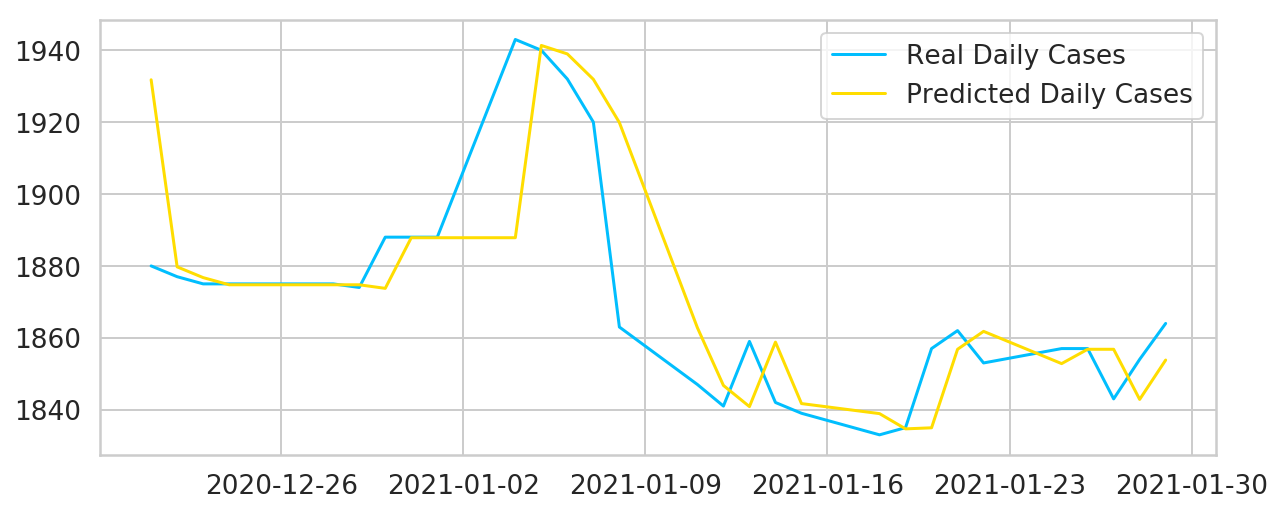

In [30]:
# plt.plot(
#   daily_cases.index[:len(train_data)], 
#   scaler.inverse_transform(train_data).flatten(),
#   label='Historical Daily Cases'
# )
plt.figure(figsize=(10,4))

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  true_cases,
  label='Real Daily Cases'
)

plt.plot(
  daily_cases.index[len(train_data):len(train_data) + len(true_cases)], 
  predicted_cases, 
  label='Predicted Daily Cases'
)

plt.legend();

## 六、改进完善方向

从上图中，我们可以看到模型大体上预测到了涨幅的升降情况，在具体数值上则出现了一些误差。读者可以发挥创造力，进一步提升模型的精度与功能，例如：

1. 预测未来n天涨幅的升降情况

我们现在是用已知的9天价格数，预测第10天的价格数，我们可以将第10天的预测结果与前8天的真实价格数拼接，预测第11天的价格数，以此类推即可预测未来n天的价格数。

2. 优化模型网络

本文采用的是TCN模型，如果不考虑模型的速度性能，可以尝试LSTM, GRU, transformer等模型，进一步提升模型的拟合能力。

3. 优化模型超参数

本文没有对超参设置进行探索，读者可以探索设置更加合理的学习率，训练轮次，TCN通道数等。
